<a href="https://colab.research.google.com/github/shahabday/NLP_learning/blob/main/Autoregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm

In [2]:
# Where the text files are going to live.
dataset_path = "dataset"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

# Just use 20 files.
file_number = 20

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):

    # Create all the folders.
    for path in [dataset_path, dataset_path_all, dataset_path_train, dataset_path_valid]:
        if not os.path.exists(path):
            os.mkdir(path)

    # Clone the repo.
    !git clone https://github.com/vilmibm/lovecraftcorpus

    # Find all the files.
    paths_all = glob.glob("lovecraftcorpus/*.txt")
    print(sorted(paths_all))

    # Standardize.
    for path in paths_all:
        content = open(path).read()
        content = content.lower()
        for punctuation in ".,:;?!":
            content = content.replace(punctuation, " " + punctuation)
        open(path, "w").write(content)

    # Do not use all.
    paths_all = paths_all[:file_number]

    # Split 80/20.
    split_index = int(len(paths_all) * 0.8)
    paths_train = paths_all[:split_index]
    paths_valid = paths_all[split_index:]

    # Copy files.
    def copy(paths, destination):
        for path in paths:
            shutil.copy2(path, destination)
    copy(paths_all, dataset_path_all)
    copy(paths_train, dataset_path_train)
    copy(paths_valid, dataset_path_valid)

    # Delete repo.
    !rm -rf lovecraftcorpus

    # Done.
    print("Corpus downloaded.")

Cloning into 'lovecraftcorpus'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 74 (delta 0), reused 3 (delta 0), pack-reused 70 (from 1)
Receiving objects: 100% (74/74), 1.12 MiB | 18.20 MiB/s, done.
['lovecraftcorpus/alchemist.txt', 'lovecraftcorpus/arthur_jermyn.txt', 'lovecraftcorpus/azathoth.txt', 'lovecraftcorpus/beast.txt', 'lovecraftcorpus/beyond_wall_of_sleep.txt', 'lovecraftcorpus/book.txt', 'lovecraftcorpus/celephais.txt', 'lovecraftcorpus/charles_dexter_ward.txt', 'lovecraftcorpus/clergyman.txt', 'lovecraftcorpus/colour_out_of_space.txt', 'lovecraftcorpus/cool_air.txt', 'lovecraftcorpus/crawling_chaos.txt', 'lovecraftcorpus/cthulhu.txt', 'lovecraftcorpus/dagon.txt', 'lovecraftcorpus/descendent.txt', 'lovecraftcorpus/doorstep.txt', 'lovecraftcorpus/dreams_in_the_witch.txt', 'lovecraftcorpus/dunwich.txt', 'lovecraftcorpus/erich_zann.txt', 'lovecraftcorpus/ex_oblivione.txt', 'love

In [3]:
batch_size  = 32  # not for SGD! This is a different batch size.
seed = 667

def create_dataset(dataset_path):
    dataset = preprocessing.text_dataset_from_directory(
        dataset_path,
        labels=None,
        batch_size=batch_size,
        seed=seed
    )
    return dataset
dataset_original_all = create_dataset(dataset_path_all)
dataset_original_train = create_dataset(dataset_path_train)
dataset_original_valid = create_dataset(dataset_path_valid)




Found 20 files.
Found 16 files.
Found 4 files.


In [4]:
vocabulary_size = 10_000
encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,
    split="whitespace",
    output_mode="int"
)
encoder.adapt(dataset_original_all)
vocabulary = encoder.get_vocabulary()
print(vocabulary[:100])

['', '[UNK]', 'the', ',', 'and', 'of', '.', 'to', 'a', 'in', 'was', 'that', 'had', 'i', 'he', 'it', 'as', 'his', 'with', ';', 'at', 'which', 'from', 'for', 'on', 'not', 'but', 'were', 'we', 'this', 'by', 'or', 'be', 'have', 'all', 'could', 'my', 'they', 'been', 'there', 'him', 'when', 'one', 'an', 'no', 'so', 'what', 'would', 'me', 'some', 'their', 'old', 'more', 'its', 'our', 'about', 'up', 'is', 'out', 'very', 'only', 'before', 'did', 'now', 'any', 'seemed', 'into', 'must', 'after', 'than', 'them', 'though', 'those', 'you', 'even', 'time', 'who', 'where', 'saw', 'through', 'great', 'if', 'then', 'man', 'ward', 'other', 'found', 'these', 'whose', 'things', 'down', 'over', 'came', 'like', 'her', 'might', 'such', 'made', 'certain', 'first']


In [5]:

sequence_length = 32
vocabulary = encoder.get_vocabulary()
padding_token_id = 0


def create_dataset_for_autoregression(dataset):
  x_inputs = []
  y_outputs = []
  for stories in dataset:
    stories = encoder(stories).numpy() # Does the padding

    for story in stories:
      story = [index for index in list(story) if index != padding_token_id] # removes padding

      # Allowing to generate from sequences that are shorter than sequence length.
      padding = [padding_token_id] * sequence_length
      story = padding + story

      for start_index in range(0,len(story)-sequence_length): # no overflow.
          x = story[start_index:start_index + sequence_length]
          assert len(x) == sequence_length, "Should not happen."
          y = story[start_index + 1 :start_index + sequence_length+1]
          assert len(y) == sequence_length , "should not happen"

          x_inputs += [x]
          y_outputs += [y]


  # Done,
  return tf.data.Dataset.from_tensor_slices((x_inputs, y_outputs))


dataset_train = create_dataset_for_autoregression(dataset_original_train)
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)

In [6]:
def decode(indices):
  return " ".join([vocabulary[index] for index in indices if vocabulary[index] != ""])

for input,output in dataset_train.take(20):
  print(decode(input))
  print(decode(output))
  print("")


the

the
the temple

the temple
the temple manuscript

the temple manuscript
the temple manuscript found

the temple manuscript found
the temple manuscript found on

the temple manuscript found on
the temple manuscript found on the

the temple manuscript found on the
the temple manuscript found on the coast

the temple manuscript found on the coast
the temple manuscript found on the coast of

the temple manuscript found on the coast of
the temple manuscript found on the coast of yucatan

the temple manuscript found on the coast of yucatan
the temple manuscript found on the coast of yucatan on

the temple manuscript found on the coast of yucatan on
the temple manuscript found on the coast of yucatan on august

the temple manuscript found on the coast of yucatan on august
the temple manuscript found on the coast of yucatan on august 20

the temple manuscript found on the coast of yucatan on august 20
the temple manuscript found on the coast of yucatan on august 20 ,

the temple manuscri

In [7]:
import matplotlib.pyplot as plt

def render_history(history):
    plt.title("Training loss vs. validation loss")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Training accuracy vs. validation accuracy")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

## Model

In [14]:
embedding_size = 16

model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size))
model.add(layers.LSTM(embedding_size, return_sequences=True) )
model.add(layers.Dense(vocabulary_size,activation="softmax"))


model.build(input_shape = (None, sequence_length))

model.summary()


model.compile (

               optimizer = 'adam',
               loss = 'sparse_categorical_crossentropy',
               metrics=["accuracy"]
)

# history = model.fit(

#                     dataset_train.cache().shuffle(10_000).batch(1024),
#                     epochs= 10 ,
#                     validation_data = dataset_valid.batch(1024)
# )

render_history(history)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 32, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32, 16)              │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32, 10000)           │         170,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 332,112 (1.27 MB)

 Trainable params: 332,112 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

NameError: name 'history' is not defined

In [ ]:
import numpy as np

def generate(model, seed_text, generated_sequence_length, temperature):

    seed_text = seed_text.lower()
    for punctuation in ".,:;?!":
        seed_text = seed_text.replace(punctuation, " " + punctuation)

    input_sequence = encoder(seed_text).numpy().tolist()

    # Generate the sequence by repeatedly predicting.
    while len(input_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0), verbose=False)
        predicted_index = get_index_from_prediction(prediction[0][-1], temperature)
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(input_sequence)
    for punctuation in ".,:;?!":
        text = text.replace(" " + punctuation, punctuation)
    print(text)
    print("")


def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature # softmax formula is : ex/sigma(ex) getting logarithm ,cancels this out
        # log amplifies x<1 , of course it negates them
        # it T is smaller than 1  , push lower peaks to higher numbers and vise versa

        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate(model, "we are all doomed", 100, temperature=1.0)

## Create Transformes

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Embedding (Embedding)     │ (None, 32, 16)         │        160,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 16)         │              0 │ Embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 32, 16)         │             32 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 32, 16)         │          4,304 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 32, 16)         │              0 │ multi_head_attention[… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 32, 16)         │             32 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32, 32)         │            544 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32, 16)         │            528 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 32, 16)         │              0 │ dense_1[0][0],         │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 32, 16)         │             32 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 32, 16)         │          4,304 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 32, 16)         │              0 │ multi_head_attention_… │
│                           │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 32, 16)         │             32 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)      

 Total params: 351,760 (1.34 MB)

 Trainable params: 351,760 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 51s 174ms/step - accuracy: 0.0309 - loss: 7.4612 - val_accuracy: 0.0678 - val_loss: 6.4396
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.0949 - loss: 6.2701 - val_accuracy: 0.1046 - val_loss: 6.2563
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.1308 - loss: 5.9027 - val_accuracy: 0.1323 - val_loss: 6.1485
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.1512 - loss: 5.6389 - val_accuracy: 0.1370 - val_loss: 6.1711
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.1599 - loss: 5.5009 - val_accuracy: 0.1392 - val_loss: 6.1933
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.1654 - loss: 5.3861 - val_accuracy: 0.1396 - val_loss: 6.2242
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.1698 - loss: 5.2768 - val_accuracy: 0.1404 - val_loss: 6.2727
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.1746 - loss: 5.1872 -

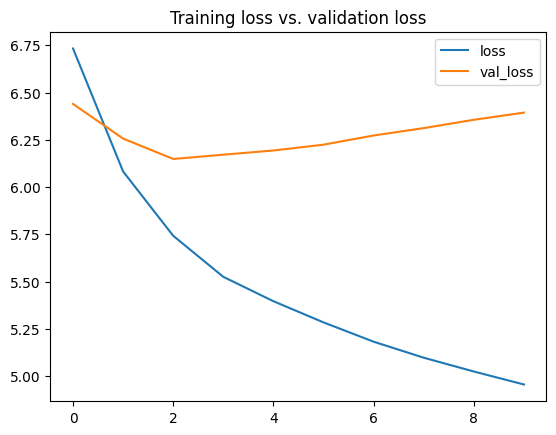

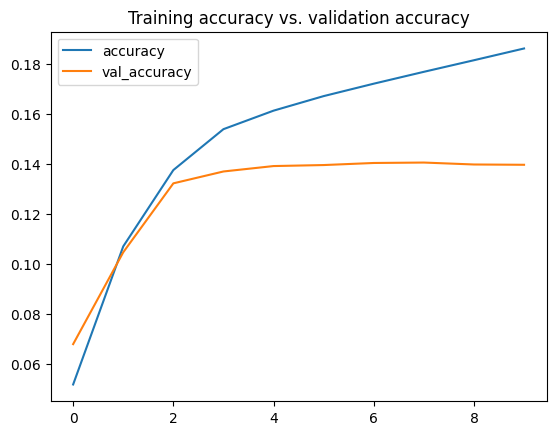

In [9]:
from re import X
def create_transformer( sequence_length = 32 , embedding_size = 16 , layers_number = 4 , num_heads=4):

  #functional API.

  inputs = tf.keras.Input(shape=(sequence_length,), dtype=tf.int32)
  embedding=layers.Embedding(vocabulary_size , embedding_size, name='Embedding')(inputs)

  positions = tf.range(start=0, limit=sequence_length, delta=1) # [0, 1, 2, ... , 31] constant
  positional_embedding = layers.Embedding(sequence_length, embedding_size,name='Positional')(positions)
  embedding += positional_embedding

  for _ in range( layers_number):

    x1 = layers.LayerNormalization(epsilon = 1e-6)(embedding)

    attention_output= layers.MultiHeadAttention(

                                                num_heads = num_heads,
                                                key_dim = embedding_size,
                                                dropout = 0.1
    )(x1,x1, use_causal_mask = True )  # V/K + Q

    # skip connection.
    x2 = attention_output + embedding
    # Normalize .
    x3 = layers.LayerNormalization(epsilon = 1e-6)(x2)

    # MLP.

    x4  = layers.Dense(embedding_size * 2 , activation = 'gelu')(x3)
    x4  = layers.Dense(embedding_size, activation = 'gelu')(x4)


    # skip connection

    embedding = x4+x2


  #Head.
  outputs = layers.Dense (vocabulary_size , activation='softmax')(embedding)
  return models.Model(inputs , outputs)




model = create_transformer()
model.summary()


model.compile (

               optimizer = 'adam',
               loss = 'sparse_categorical_crossentropy',
               metrics=["accuracy"]
)

history = model.fit(

                    dataset_train.cache().shuffle(10_000).batch(1024),
                    epochs= 10 ,
                    validation_data = dataset_valid.batch(1024)
)

render_history(history)



In [12]:
def generate_with_padding(model, seed_text, generated_sequence_length, temperature):
    seed_text = seed_text.lower()
    for punctuation in ".,:;?!":
        seed_text = seed_text.replace(punctuation, " " + punctuation)


    input_sequence = encoder(seed_text).numpy().tolist()

    # Pad the input_sequence if it's shorter than sequence_length
    if len(input_sequence) < sequence_length:
        input_sequence = [0] * (sequence_length - len(input_sequence)) + input_sequence

    # Generate the sequence by repeatedly predicting.
    while len(input_sequence) < generated_sequence_length:
        sequence = input_sequence[-sequence_length:]
        assert len(sequence) == sequence_length

        prediction = model.predict(np.expand_dims(sequence, axis=0), verbose=False)
        predicted_index = get_index_from_prediction(prediction[0][-1], temperature)

        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(input_sequence)
    for punctuation in ".,:;?!":
        text = text.replace(" " + punctuation, punctuation)
    text = text.strip()
    print(text)
    print("")

generate_with_padding(model, "The Shadow out of time", 100, temperature=1.2)

the shadow out of time. we had approached behind the smell in so one of dry, heavy wall appeared to living gate of the bodies; gifted what [UNK] temples. but pabodie lay it could dismiss its golden aether and they was terrible eery story mollusks, and pierced sixteen shops above four strained a steep cities who glanced, upon like a foot which dissolved the land of the

